# Analyse des couts et tokens
Notebook pour agreger les logs `costs.csv`, estimer les couts par scenario et generer des visualisations (histogrammes, boxplots, courbes cumulatives). Ajustez les tarifs dans la cellule dediee avant d'executer.

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

COSTS_PATH = Path("costs.csv")
df = pd.read_csv(COSTS_PATH)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.head()

,timestamp,scenario_id,call_id,model,endpoint,prompt_hash,prompt_tokens,completion_tokens,total_tokens,latency_ms,status,notes
0,2025-12-17 20:24:08.266960+00:00,session-mjagm464-j6v1,3711bf84-fec8-46af-b1d8-40cb61686975,gemma3:4b,http://localhost:11434/api/chat,298d31411f484d613fe4c846c44d9b97017c3dccfac373...,292,57,349,4720,success,prompt_optimizer.optimize
1,2025-12-17 20:24:14.616777+00:00,session-mjagm464-j6v1,cdfe89e2-5a75-4aa8-873e-0421c7483a36,qwen2.5,http://localhost:11434/api/chat,34ab68725684cff9639534bb4af264ae297f0eeaabfef8...,522,129,651,6348,success,planner.plan
2,2025-12-17 20:24:36.261714+00:00,session-mjagm464-j6v1,87f37465-3551-4abc-afda-aec95f533ed3,codellama:13b,http://localhost:11434/api/chat,4a7d3cf4f53b5bb9b4a675fb2095ed8485aeb9030af66c...,764,115,879,21643,success,executor.execute task=1
3,2025-12-17 20:24:40.991578+00:00,session-mjagm464-j6v1,bbb4c811-d650-4bb0-a897-9bb3b8d536e5,qwen2.5,http://localhost:11434/api/chat,c2d22bb64c83bf4ed88ff9392b35d27f361423367894be...,429,29,458,4728,success,reviewer.review task=1
4,2025-12-17 20:24:45.015308+00:00,session-mjagm464-j6v1,fccb8115-85d7-47d0-98a0-140815dc6be4,qwen2.5,http://localhost:11434/api/chat,48457be1c9657ad10b3fcf8d9eeffa9204a2c6520e2cdb...,692,97,789,4022,success,critic.evaluate_final


In [2]:
# Total de tokens par scenario
agg_tokens = (
    df.groupby("scenario_id")[["prompt_tokens", "completion_tokens", "total_tokens"]]
    .sum()
    .sort_values("total_tokens", ascending=False)
)
agg_tokens

,prompt_tokens,completion_tokens,total_tokens
scenario_id,,,
session-mjagp3ek-guvk,5893,951,6844
session-mjagm464-j6v1,5703,958,6661


In [4]:
# Estimation des couts (USD) par appel, puis par scenario.
PROMPT_RATES_PER_1K = {
    "default": 0.0,
    "gemma3:4b": 0.0001,
    "codellama:13b": 0.0005,
    "qwen2.5": 0.0002,
}
COMPLETION_RATES_PER_1K = {
    "default": 0.0,
    "gemma3:4b": 0.0002,
    "codellama:13b": 0.0008,
    "qwen2.5": 0.0003,
}

def estimate_cost(row: pd.Series) -> float:
    prompt_rate = PROMPT_RATES_PER_1K.get(row["model"], PROMPT_RATES_PER_1K["default"])
    completion_rate = COMPLETION_RATES_PER_1K.get(row["model"], COMPLETION_RATES_PER_1K["default"])
    return (row["prompt_tokens"] / 1000.0) * prompt_rate + (row["completion_tokens"] / 1000.0) * completion_rate

df["estimated_cost_usd"] = df.apply(estimate_cost, axis=1)
costs_by_scenario = df.groupby("scenario_id")["estimated_cost_usd"].sum().sort_values(ascending=False)
costs_by_scenario.head(10)


scenario_id
session-mjagp3ek-guvk    0.001899
session-mjagm464-j6v1    0.001875
Name: estimated_cost_usd, dtype: float64

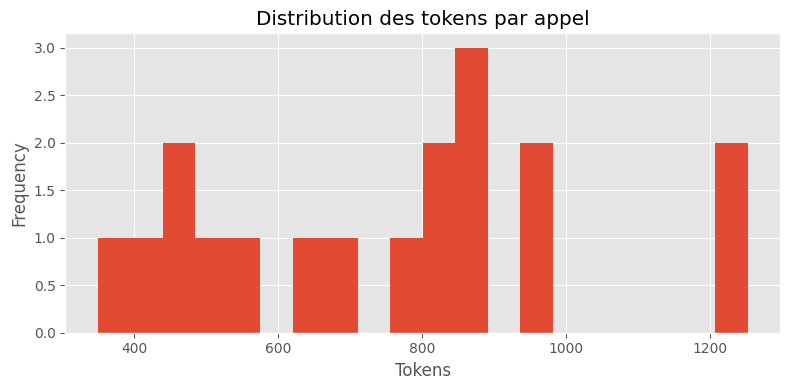

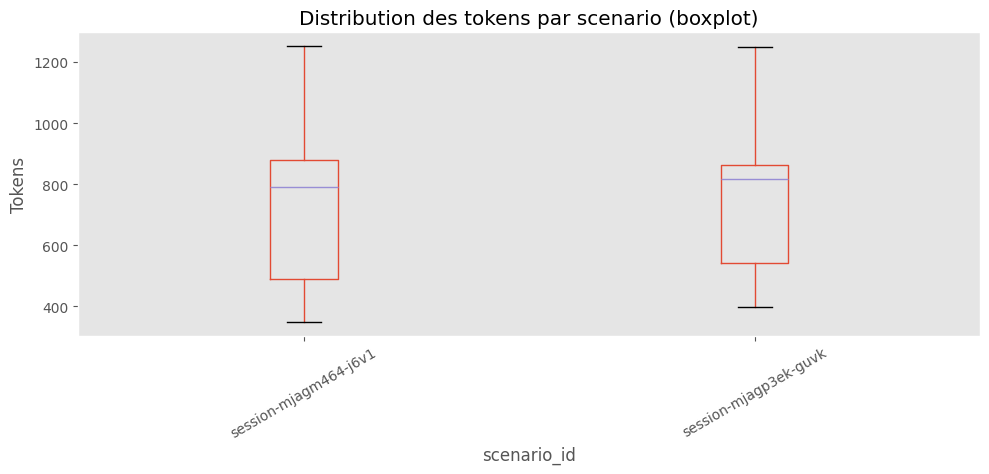

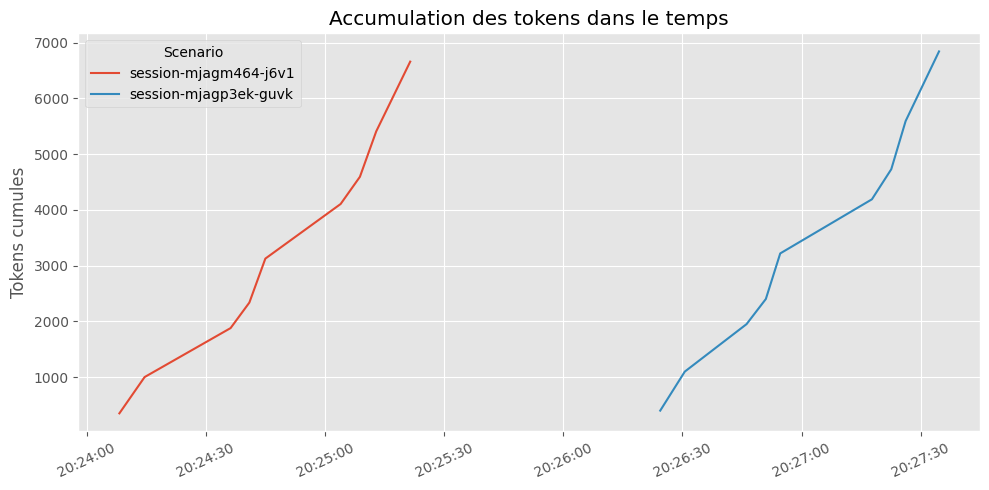

In [5]:
# Visualisations: histogramme, boxplot par scenario, courbe cumulative
plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=(8, 4))
df["total_tokens"].plot(kind="hist", bins=20, ax=ax, title="Distribution des tokens par appel")
ax.set_xlabel("Tokens")
plt.tight_layout()

fig, ax = plt.subplots(figsize=(10, 5))
df.boxplot(column="total_tokens", by="scenario_id", ax=ax, grid=False, rot=30)
ax.set_ylabel("Tokens")
ax.set_title("Distribution des tokens par scenario (boxplot)")
plt.suptitle("")
plt.tight_layout()

df_sorted = df.sort_values("timestamp")
fig, ax = plt.subplots(figsize=(10, 5))
for scenario, group in df_sorted.groupby("scenario_id"):
    ax.plot(group["timestamp"], group["total_tokens"].cumsum(), label=scenario)
ax.legend(title="Scenario")
ax.set_ylabel("Tokens cumules")
ax.set_title("Accumulation des tokens dans le temps")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

In [6]:
# Tableau des appels les plus couteux (tokens) pour prioriser l'optimisation.
top_calls = df.sort_values("total_tokens", ascending=False)[
    ["timestamp", "scenario_id", "model", "endpoint", "total_tokens", "status", "notes"]
].head(20)
top_calls

,timestamp,scenario_id,model,endpoint,total_tokens,status,notes
8,2025-12-17 20:25:21.485681+00:00,session-mjagm464-j6v1,gemma3:4b,http://localhost:11434/api/chat,1252,success,responder.build_markdown_response
17,2025-12-17 20:27:34.616202+00:00,session-mjagp3ek-guvk,gemma3:4b,http://localhost:11434/api/chat,1250,success,responder.build_markdown_response
5,2025-12-17 20:25:03.966582+00:00,session-mjagm464-j6v1,codellama:13b,http://localhost:11434/api/chat,980,success,self_correction task=1
14,2025-12-17 20:27:17.721102+00:00,session-mjagp3ek-guvk,codellama:13b,http://localhost:11434/api/chat,971,success,self_correction task=1
2,2025-12-17 20:24:36.261714+00:00,session-mjagm464-j6v1,codellama:13b,http://localhost:11434/api/chat,879,success,executor.execute task=1
16,2025-12-17 20:27:26.208165+00:00,session-mjagp3ek-guvk,qwen2.5,http://localhost:11434/api/chat,864,success,critic.evaluate_final
11,2025-12-17 20:26:46.161723+00:00,session-mjagp3ek-guvk,codellama:13b,http://localhost:11434/api/chat,852,success,executor.execute task=1
13,2025-12-17 20:26:54.639919+00:00,session-mjagp3ek-guvk,qwen2.5,http://localhost:11434/api/chat,818,success,critic.evaluate_final
7,2025-12-17 20:25:12.925425+00:00,session-mjagm464-j6v1,qwen2.5,http://localhost:11434/api/chat,815,success,critic.evaluate_final
4,2025-12-17 20:24:45.015308+00:00,session-mjagm464-j6v1,qwen2.5,http://localhost:11434/api/chat,789,success,critic.evaluate_final
